<a href="https://colab.research.google.com/github/jjh99k/ml/blob/main/Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Lab Session 3

This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
- <font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.
- Commit the `.ipynb` file on your github repository and submit URL on E-Ruri

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Preparing Dataset

### Load MNIST Data
We temperaly use `sklearng.datasets` for load MNIST before we learning `pytorch`.

In [2]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X / 255.0
y = y.astype(int)

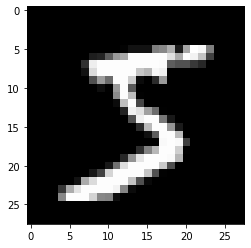

In [3]:
plt.imshow(X[0].reshape((28, 28)), cmap='gray')
plt.show()

### Preprocessing
Reformat into a shape that's more adapted to the models we're going to train:
1. labels as float 1-hot encodings. [hint, use [`np.eye`](https://numpy.org/devdocs/reference/generated/numpy.eye.html)] **[pts. 5]**
2. split the data into train and test


In [4]:
# one-hot encoding
print('before encoding: %s'% y[0])
y = np.eye(10)[y]
print('after encoding: %s' % y[0])

before encoding: 5
after encoding: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [5]:
from sklearn.model_selection import train_test_split

# Split data into train partition and test partition
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.2)

IMAGE_SIZE = 28
NUM_LABELS = 10

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (56000, 784) (56000, 10)
Test set (14000, 784) (14000, 10)


In this lab session, we only use partial data for training and test.

In [6]:
DATA_SIZE = 100

X_train = X_train[0:DATA_SIZE]
y_train = y_train[0:DATA_SIZE]

X_test = X_test[0:DATA_SIZE]
y_test = y_test[0:DATA_SIZE]

## Training a Neural Networks


### Activation Function

First let's implement two activation function, `sigmoid` and `softmax`. Also the derivation of `sigmoid` function. **[pts. 5 per function]**
$$
\begin{align}
\sigma(x) &=  \frac{\mathrm{1} }{\mathrm{1} + e^{-x} } \\
\mathrm{softmax}(x_{i}) &= \frac{e^{x_i}}{\sum_j e^{x_j}} \\
\sigma'(x) &= \sigma(x)\sigma(1-x) \\
\end{align}
$$

In [36]:
def sigmoid(Z):
    return 1 / (1+np.exp(-Z))

def softmax(Z):
    return np.exp(Z) / np.exp(Z).sum(axis = 0, keepdims=True)

def sigmoid_derivative(Z):
    s = 1 / (1+np.exp(-Z))
    return s * (1-s)

In [37]:
# test functions
print(sigmoid(0.1))
print(softmax([0.15, 0.8, 0.05]))
print(sigmoid_derivative(0.1))

0.52497918747894
[0.26175419 0.50140083 0.23684498]
0.24937604019289197


Let's now build a neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 784. Similarly, the number of nodes in the output layer is determined by the number of classes we have, 10. The input to the network will be the pixel values of the input image and its output will be ten probabilities, ones for each class.

![Sample network](https://drive.google.com/uc?id=1D1XuhvNokK5S5yn8V34JGvyE-XXz9rST)

### How our network makes predictions

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 784-dimensional input to our network then we calculate our prediction $\hat{y}$ (ten-dimensional) as follows:

$$
\begin{aligned}
\mathbf{s}_1 & = W_1\mathbf{x} + \mathbf{b}_1 \\
\mathbf{z}_1 & = \mathrm{sigmoid}(\mathbf{s}_1) \\
\mathbf{s}_2 & = W_2\mathbf{z}_1 + \mathbf{b}_2 \\
\mathbf{h} & = \hat{y} = \mathrm{softmax}(\mathbf{s}_2)
\end{aligned}
$$

$z_i$ is the input of layer $i$ and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices.

If we use 1024 nodes for our hidden layer then $W_1 \in \mathbb{R}^{1024\times784}$, $b_1 \in \mathbb{R}^{1024\times1}$, $W_2 \in \mathbb{R}^{10\times1024}$, $b_2 \in \mathbb{R}^{10\times1}$. Now you see why we have more parameters if we increase the size of the hidden layer.

**[note]** beware of dimension of $\mathbf{x}$

In [9]:
layers_size = [784, 50, 10]

Define parameters and initialize them with `np.random.rand` for W and `np.zeros` for b. **[pts. 5]**

In [10]:
# initialization
np.random.seed(1)

parameters = {}
parameters["W1"] = np.random.randn(layers_size[1], layers_size[0]) / np.sqrt(layers_size[0])
parameters["b1"] = np.zeros((layers_size[1], 1))

parameters["W2"] = np.random.randn(layers_size[2], layers_size[1]) / np.sqrt(layers_size[1])
parameters["b2"] = np.zeros((layers_size[2], 1))

print(parameters["W1"].shape)
print(parameters["b1"].shape)
print(parameters["W2"].shape)
print(parameters["b2"].shape)

(50, 784)
(50, 1)
(10, 50)
(10, 1)


Feed forward $\mathbf{x}$ through Networks. **[pts. 10]**

In [11]:
# forward
store = {}
store['X'] = X_train.T

## input to hidden
S = parameters["W1"].dot(store['X']) + parameters["b1"]
Z = sigmoid(S)
store["Z"] = Z
store["W1"] = parameters["W1"]
store["S1"] = S

## hidden to output
S = parameters["W2"].dot(Z) + parameters["b2"]
H = softmax(S)
store["H"] = H        
store["W2"] = parameters["W2"]
store["S2"] = S      

print(store["Z"].shape)
print(store["H"].shape)

(50, 100)
(10, 100)


### Learning the Parameters

Learning the parameters for our network means finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the *loss function*. A common choice with the softmax output is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



The formula looks complicated, but all it really does is sum over our training examples and add to the loss if we predicted the incorrect class. So, the further away $y$ (the correct labels) and $\hat{y}$ (our predictions) are, the greater our loss will be. 

Remember that our goal is to find the parameters that minimize our loss function. We can use [gradient descent](http://cs231n.github.io/optimization-1/) to find its minimum. I will implement the most vanilla version of gradient descent, also called batch gradient descent with a fixed learning rate. Variations such as SGD (stochastic gradient descent) or minibatch gradient descent typically perform better in practice. So if you are serious you'll want to use one of these, and ideally you would also [decay the learning rate over time](http://cs231n.github.io/neural-networks-3/#anneal).

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$. To calculate these gradients we use the famous *backpropagation algorithm*, which is a way to efficiently calculate the gradients starting from the output. I won't go into detail how backpropagation works, but there are many excellent explanations ([here](http://colah.github.io/posts/2015-08-Backprop/) or [here](http://cs231n.github.io/optimization-2/)) floating around the web.

Applying the backpropagation formula we find the following (trust me on this): **[pts. 20]**

backpropagation for output layer
$$
\begin{aligned}
& \mathbf{e} = \hat{y} - y \\
& \delta_2 = \mathbf{e} \sigma'(\mathbf{s}_2) \\
& \frac{\partial{L}}{\partial{W_2}} = \mathbf{z}^T \delta_2  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_2 \\ \\
\end{aligned}
$$

backpropagation for hidden layer
$$
\begin{aligned}
& \delta_1 = W_2^T\delta_2 \circ \sigma'(\mathbf{s}_1)  \\
& \frac{\partial{L}}{\partial{W_1}} = \mathbf{x}^T \delta_1\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_1 \\
\end{aligned}
$$

In [12]:
n = X_train.shape[0]
derivatives = {}

# backward
## output to hidden
error = store["H"] - y_train.T
deleta2 = error * sigmoid_derivative(store["S2"])

dW = deleta2.dot(store["Z"].T)
db = np.sum(deleta2, axis=1, keepdims=True)

derivatives["dW2"] = dW
derivatives["db2"] = db

## hidden to intput
dAPrev = store["W2"].T.dot(deleta2)
deleta1 = dAPrev * sigmoid_derivative(store["S1"])

dW = deleta1.dot(store["X"].T)
db = np.sum(deleta1, axis=1, keepdims=True)

derivatives["dW1"] = dW
derivatives["db1"] = db

print(derivatives['dW1'].shape)
print(derivatives['db1'].shape)
print(derivatives['dW2'].shape)
print(derivatives['db2'].shape)

(50, 784)
(50, 1)
(10, 50)
(10, 1)


### Gradient Descent
Update via gradient descent as follows: **[pts. 10]**
$$
\mathbf{w} \leftarrow \mathbf{w} - \eta ∇\frac{\partial \varepsilon}{\partial\mathbf{w}}
$$

In [13]:
learning_rate = 0.01

parameters["W2"] = parameters["W2"] - learning_rate * derivatives["dW2"]
parameters["b2"] = parameters["b2"] - learning_rate * derivatives["db2"]

parameters["W1"] = parameters["W1"] - learning_rate * derivatives["dW1"]
parameters["b1"] = parameters["b1"] - learning_rate * derivatives["db1"]

## Implementation of Whole Code

Finally, here comes the function to train our Artificial Neural Network as class. Complete the code. **[pts. 30]**

In [46]:
class ANN:
    def __init__(self, layers_size):
        self.layers_size = layers_size
        self.parameters = {}
        self.L = len(self.layers_size)
        self.n = 0
        self.costs = []
        self.val_costs = []
 
    def sigmoid(self, Z):
        return sigmoid(Z)
 
    def softmax(self, Z):
        return softmax(Z)
        ##return ###################################

    def sigmoid_derivative(self, Z):
        return sigmoid_derivative(Z)
        ##return #############
 
    def initialize_parameters(self):
        np.random.seed(1)
        ########### complete the code ################
        self.parameters["W1"] = parameters["W1"]
        self.parameters["b1"] = parameters["b1"]

        self.parameters["W2"] = parameters["W2"]
        self.parameters["b2"] = parameters["b2"]




        ##############################################

    def forward(self, X):
        store = {}
        store['X'] = X.T
        
        ########### complete the code ################
        S = self.parameters["W1"].dot(store['X']) + self.parameters["b1"]
        Z = self.sigmoid(S)
        store["Z"] = Z
        store["W1"] = self.parameters["W1"]
        store["S1"] = S

        S = self.parameters["W2"].dot(store["Z"]) + self.parameters["b2"]
        H = self.softmax(S)
        store["H"] = Z
        store["W2"] = self.parameters["W2"]
        store["S2"] = S








        ##############################################

        return H, store
 
    def backward(self, X, Y, store):
        ########### complete the code ################
        derivatives = {}

        error = store["H"] - Y.T
        deleta2 = error * self.sigmoid_derivative(store["S2"])

        dW = deleta2.dot(store["Z"].T)
        db = np.sum(deleta2, axis=1, keepdims=True)

        derivatives["dW2"] = dW
        derivatives["db2"] = db

        dAPrev = store["W2"].T.dot(deleta2)
        deleta1 = dAPrev * sigmoid_derivative(store["S1"])

        dW = deleta1.dot(store["X"].T)
        db = np.sum(deleta1, axis=1, keepdims=True)

        derivatives["dW1"] = dW
        derivatives["db1"] = db




        ##############################################
 
        return derivatives
 
    def fit(self, X, Y, learning_rate=0.01, n_iterations=2500):
        np.random.seed(1)
 
        self.n = X.shape[0]
        self.layers_size.insert(0, X.shape[1])
        self.initialize_parameters()

        for loop in range(n_iterations):
            H, store = self.forward(X)
            cost = -np.mean(Y * np.log(H.T+ 1e-8))
            derivatives = self.backward(X, Y, store)
 
            for l in range(1, self.L + 1):
                # gradient descent
                ########### complete the code ################
                self.parameters["W2"] = self.parameters["W2"] - learning_rate * self.derivatives["dW2"]
                self.parameters["b2"] = self.parameters["b2"] - learning_rate * self.derivatives["db2"]

                self.parameters["W1"] = self.parameters["W1"] - learning_rate * self.derivatives["dW1"]
                self.parameters["b1"] = self.parameters["b1"] - learning_rate * self.derivatives["db1"]




                ##############################################

            if loop % 10 == 0:
                print("[%3d/%3d] Cost: %.4f"%(loop, n_iterations, cost),
                      "Train Accuracy: %2.2f"%(self.predict(X, Y)))
 
            self.costs.append(cost)
            H, store = self.forward(X_test)
            val_cost = -np.mean(y_test * np.log(H.T+ 1e-8))            
            self.val_costs.append(val_cost)
 
    def predict(self, X, Y):
        A, cache = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100
 
    def plot_cost(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.plot(np.arange(len(self.val_costs)), self.val_costs)
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.show()

Build Model with 50 number of hidden units and train it.



In [47]:
layers_dims = [50, 10]

ann = ANN(layers_dims)
ann.fit(X_train, y_train, learning_rate=.01, n_iterations=200)
print("Train Accuracy: %.4f" % ann.predict(X_train, y_train))
print("Test Accuracy: %.4f" % ann.predict(X_test, y_test))
ann.plot_cost()

ValueError: ignored